# Build an efficient supervised word translator

Based on : "Exploiting Similarities among Languages for Machine Translation" of Tomas Mikolov, Quoc V. Le & Ilya Sutskever (2013)

In [1]:
import io

import numpy as np
from numpy import dot
from numpy.linalg import norm

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

In [2]:
# load function for pretrained versions of word embeddings
def load_embeddings(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [3]:
eng_path = '/Users/louismonier/Downloads/Monolingual/wiki.en.vec' 
fr_path = '/Users/louismonier/Downloads/Monolingual/wiki.fr.vec'
nmax = 50000  # maximum number of word embeddings to load

# load monolingual word embeddings 
src_embeddings, src_id2word, src_word2id = load_embeddings(fr_path, nmax) # source = french 
tgt_embeddings, tgt_id2word, tgt_word2id = load_embeddings(eng_path, nmax) # target = english

### FRENCH to ENGLISH translation

* source language = french
* target language = english

In [4]:
# load ground-truth bilingual dictionaries function
def load_dic(path):
    dico_full = {}
    vectors_src=[]
    vectors_tgt = []
    with io.open(path,'r',encoding='utf_8') as f:
        for i,line in enumerate(f):
            word_src, word_tgt = line.rstrip().split(' ',1)
            if word_tgt in tgt_word2id :
                dico_full[word_src]=word_tgt
    for key in dico_full.keys() :
            vectors_src.append(src_embeddings[src_word2id[key]])
            vectors_tgt.append(tgt_embeddings[tgt_word2id[dico_full[key]]])
    X = np.vstack(vectors_src)
    Z = np.vstack (vectors_tgt)
    return dico_full,X,Z

In [5]:
# train & test bilingual dictionaries
path_train = r'/Users/louismonier/Downloads/Monolingual/fr-en.0-5000.txt' 
path_test = r'/Users/louismonier/Downloads/Monolingual/fr-en.5000-6500.txt'
dico_train, X_train, Z_train = load_dic(path_train)
dico_test, X_test, Z_test = load_dic(path_test) 

## Part I - Build a learning a linear mapping from a source (french) to a target (english) embedding space thanks to a translation Matrix W 

Suppose we are given a set of word pairs and their associated vector representations ${ \{x_i , z_i\} }^{n}_{i=1}$ , where $x_i$ ∈ $R^{d1}$ is the distributed representation of word i in the source language, and $z_i$ ∈ $R^{d2}$ is the vector representation of its translation.

It is our goal to find a transformation matrix W such that W xi approximates $z_i$ . In practice, W can be learned by the following optimization problem :

$$ \underset{W}{min} C (W) = \underset{W}{min} \sum_{i=1}^{n} \| W x_i - z_i \|^2 $$ 

which we solve with gradient descent (GD), stochastic gradient descent (SGD) or mini-batch gradient descent (BGD).

In [6]:
print(X_train.shape[0], "training samples")
print(X_test.shape[0], "test samples")

print("d1 dimension :", X_train.shape[1])
print("d2 dimension :", X_test.shape[1])

4971 training samples
1483 test samples
d1 dimension : 300
d2 dimension : 300


In [7]:
# function to minimize 
# normalisation added
def C(W,X,Z):
    S = 0
    S = sum(np.linalg.norm(np.dot(X, W.T) - Z, axis=1)**2) 
    return S

In [8]:
# gradient of the function to minimize
# normalisation added
def GradW(W,X,Z):
    G = np.zeros((Z_train.shape[1], X_train.shape[1]))
    G = 2*np.dot(X.T, (np.dot(X, W.T) - Z)).T
    return G

In [9]:
# GD function
def GradientDescent(eta, niter): 
    W = np.random.rand(300,300) # random initialisation of W
    value_C = np.zeros(niter)
    for t in range(niter): 
        value_C[t] = (1/(X_train.shape[0])) * C(W,X_train,Z_train)
        W -= (1/X_train.shape[0])*eta*GradW(W,X_train,Z_train)
    print("GD done...")
    return (W, value_C) #,acc_test,acc_train)

In [10]:
# SGD function
def StochasticGradientDescent(eta, niter):
    # initialisation
    W = np.random.rand(Z_train.shape[1],Z_train.shape[1]) # random initialisation of W
    grad = np.zeros((Z_train.shape[1], X_train.shape[1]))
    value_C = np.zeros(niter)
    X_i = np.zeros(X_train.shape[1])
    Z_i = np.zeros(X_train.shape[1])
    
    for t in range(niter):
        rand_ind = np.random.randint(0, X_train.shape[0]) 
        X_i = X_train[rand_ind,:]
        Z_i = Z_train[rand_ind,:]    
        W -= eta*2*np.dot(X_i.T, (np.dot(X_i, W.T) - Z_i)).T   
        value_C[t] = np.linalg.norm(np.dot(W, X_i) - Z_i)**2
    print("SGD done...")
    return (W, value_C)

In [11]:
# BGD function
def BatchGradientDescent(eta, niter, batch_size):
    # initialisation
    N = X_train.shape[0]
    W = np.random.rand(Z_train.shape[1],Z_train.shape[1]) # random initialisation of W
    grad = np.zeros((Z_train.shape[1], X_train.shape[1]))
    value_C = np.zeros(niter)
    n_batchs = int(N/batch_size)
    
    for t in range(niter):
        indices = np.random.permutation(N)
        X_ind = X_train[indices]
        Z_ind = Z_train[indices]
        for i in range(0,N,n_batchs):
            X_i = X_ind[i:i+batch_size]
            Z_i = Z_ind[i:i+batch_size]
            W -= eta*2*np.dot(X_i.T, (np.dot(X_i, W.T) - Z_i)).T  
        value_C[t] = (1/(batch_size)) * C(W,X_i,Z_i)
    print("MGD done...")
    return (W, value_C)

### Train the model
The goal is to find the best W to map the source language to the target one.

In [12]:
eta = 0.3
niter = 100
batch_size = 1000

W_GD, C_GD = GradientDescent(eta, niter) # GD
#W_SGD, C_SGD = StochasticGradientDescent(eta, niter) # SGD
#W_BGD, C_BGD = BatchGradientDescent(eta, niter, batch_size) # BGD

GD done...


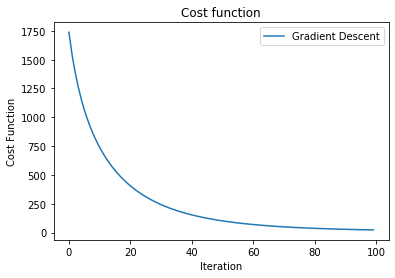

In [13]:
plt.plot(range(niter), C_GD, label="Gradient Descent")
#plt.plot(range(niter), C_SGD, label="Stochastic Gradient Descent")
#plt.plot(range(niter), C_BGD, label="Batch Gradient Descent")
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
plt.title("Cost function")
plt.legend()
plt.show()

WTF pour le SGD et le BGD ?
Ca bug grave... Mais pas très important
=> Pour BGD: cela vient de la size de batch trop grand (n = 1000) et donc qd on fait X_i = X_ind[i:i+batch_size] ça dépasse la taille de X_ind
=> Pour SGD: eta = 0.3 nest pas trop grand? Ce sera mieux en déduisant eta, eta = 0.1 par example ?

In [14]:
# Fastest training
Wmin = np.dot(np.linalg.pinv(X_train), Z_train).T 

### Testing the model

At the prediction time, for any given new word and its continuous vector representation x, we can map it to the other language space by computing $z = Wx$. Then, we find the word whose representation is closest to z in the target language space, using cosine similarity as the distance metric.

In [15]:
def prediction(W, new_word, k=5):
    x = src_embeddings[src_word2id[new_word]] # vector representation of new_word in the source space
    z = np.dot(W, x) # vector representation of the translated word in the target space

    # representation closest to z in the target language space, using cosine similarity as the distance metric
    z_pred1 = np.argmax(sklearn.metrics.pairwise.cosine_similarity(z.reshape(1,300),tgt_embeddings))

    # top k closest word embeddings in the target space
    z_predk = sklearn.metrics.pairwise.cosine_similarity(z.reshape(1,300),tgt_embeddings)[0].argsort()[-k:][::-1]
    
    return [tgt_id2word[z_pred1]], [tgt_id2word[z_predk[i]] for i in range(len(z_predk))]  # return the id of the translated word

In [16]:
# just a litte test
top1, top5 = prediction(W_GD, "bateau", k=5)
print("Top 1 translation for 'bateau' is :", top1)
print("Top 5 translations for 'bateau' are :", top5)

Top 1 translation for 'bateau' is : ['boat']
Top 5 translations for 'bateau' are : ['boat', 'boats', 'sailing', 'steamer', 'yacht']


In [17]:
# construct a translation French to English dictionary
def prediction_dict(dico, W, kk):
    dico_pred1 = {}
    dico_predk = {}
    i = 0
    for word in dico.keys() :
        if (i%100==0):
            print("Progress :", round(i/len(dico_test)*100,1), "%")
        dico_pred1[word], dico_predk[word] = prediction(W, word, k) # lists
        i += 1
    print("Done...")
    return dico_pred1, dico_predk

In [18]:
# test predictions for W from GD

# k-top accuracy ("acc@k")
k = 5

dico_pred1, dico_predk = prediction_dict(dico_test, W_GD, k) 
dico_pred1_best, dico_predk_best = prediction_dict(dico_test, Wmin, k) 

Progress : 0.0 %
Progress : 6.7 %
Progress : 13.5 %
Progress : 20.2 %
Progress : 27.0 %
Progress : 33.7 %
Progress : 40.5 %
Progress : 47.2 %
Progress : 53.9 %
Progress : 60.7 %
Progress : 67.4 %
Progress : 74.2 %
Progress : 80.9 %
Progress : 87.7 %
Progress : 94.4 %
Done...
Progress : 0.0 %
Progress : 6.7 %
Progress : 13.5 %
Progress : 20.2 %
Progress : 27.0 %
Progress : 33.7 %
Progress : 40.5 %
Progress : 47.2 %
Progress : 53.9 %
Progress : 60.7 %
Progress : 67.4 %
Progress : 74.2 %
Progress : 80.9 %
Progress : 87.7 %
Progress : 94.4 %
Done...


In [19]:
# measure of the accuracy of the dictionnary
# output is a list
def accuracy(dpred1, dpredk, dico):
    acc1 = [0]
    acck = [0]
    
    for key in dico.keys():
        add1, addk = 0, 0
        
        if dico[key] == dpred1[key][0]:
            add1 = 1
        acc1.append(acc1[-1] + add1)  
    
        for i in np.arange(k):
            if dico[key] == dpredk[key][i]:
                addk = 1
                break   
        acck.append(acck[-1] + addk) 
    
    acc1 = [i/len(dico) for i in acc1]   
    acck = [i/len(dico) for i in acck]
    
    return acc1, acck # nb de mots bien prédits/nb de mots total     

In [20]:
# measure of the accuracy of the dictionnary
# output is just final result
def fast_accuracy(dpred1, dpredk, dico):
    acc1 = 0
    acck = 0
    for key in dico.keys():     
        if dico[key] == dpred1[key][0]:
            acc1 += 1
        
        for i in np.arange(k):
            if dico[key] == dpredk[key][i]:
                acck += 1
                break   
                
    acc1 /= len(dico)
    acck /= len(dico)
    
    return acc1, acck # nb de mots bien prédits/nb de mots total     

In [21]:
acc1_test, acck_test = accuracy(dico_pred1, dico_predk, dico_test)
acc1_test_best, acck_test_best = accuracy(dico_pred1_best, dico_predk_best, dico_test)

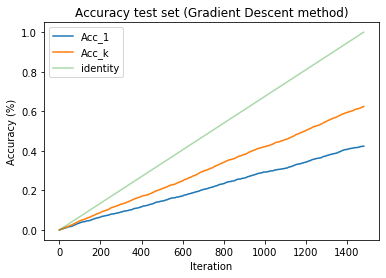

Gradient descent method :
Final accuracy @1 = 42.35 %
Final accuracy @5 = 62.37 %

Analytical method :
Final accuracy @1 = 60.22 %
Final accuracy @5 = 77.14 %


In [22]:
plt.plot(acc1_test, label="Acc_1")
plt.plot(acck_test,label="Acc_k")
plt.plot([i/len(dico_test) for i in range(len(dico_test))],label="identity",alpha=0.4)
plt.ylabel('Accuracy (%)')
plt.xlabel('Iteration')
plt.title("Accuracy test set (Gradient Descent method)")
plt.legend()
plt.show()

print("Gradient descent method :")
print("Final accuracy @1 =", round(acc1_test[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test[-1]*100, 2), "%")
print("")
print("Analytical method :")
print("Final accuracy @1 =", round(acc1_test_best[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test_best[-1]*100, 2), "%")

### Annex part I

GD done...
GD done...
GD done...
GD done...
GD done...
GD done...


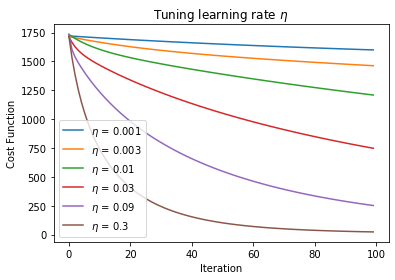

In [23]:
# Hyper parameter sensitivity
eta_list = np.array([0.001, 0.003, 0.01, 0.03, 0.09, 0.3]) 
niter = 100

plt.clf

for ieta in np.arange(0,eta_list.size):
    eta = eta_list[ieta]
    W_GD, C_GD = GradientDescent(eta, niter)
    plt.plot(C_GD, label='$\eta$ = %s' % eta_list[ieta])
    
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
plt.title("Tuning learning rate $\eta$")
plt.legend()

plt.show()

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in dico_train.keys():
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    nsamples = 20
#print(np.random.choice(X_train.shape[0], nsamples))
      
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_embeddings = np.asfarray(X_train[:128], dtype='float')
low_dim_embs = tsne.fit_transform(plot_embeddings)
plt.scatter(low_dim_embs[:,0], low_dim_embs[:,1], marker='*')#, labels)


plt.title('Visualization of the multilingual word embedding space')

list_words = np.random.choice(list(dico_train.keys()),nsamples)
print(len(d))
for i in range(0,nsamples):
    plt.annotate(list_words[i], xy=(low_dim_embs[127+i,0], low_dim_embs[127,1]),
                 xytext=(0, 0), textcoords='offset points', fontsize=10,color='red')

plt.show()

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

## Part II - Adressing the inconsistency

Based on : 
* "Normalized Word Embedding and Orthogonal Transform for Bilingual Word Translation" of Chao Xing, Dong Wang, Chao Liu & Yiye Lin (2015)

(Xing et al. (2015) argued that Mikolov’s linear matrix should be orthogonal, and introduced an
approximate procedure composed of gradient descent updates and repeated applications of the SVD)

* "Offline bilingual word vectors, orthogonal transformations and the inverted softmax" of Samuel L. Smith, David H. P. Turban, Steven Hamblin & Nils Y. Hammerla


**Intuition :**
A self-consistent linear transformation between vector
spaces should be orthogonal. Intuitively, the transformation is a rotation, and it is found using the
singular value decomposition (SVD). The SVD aligns the translations remarkably well.



If $W$ maps the source language into the target, then $W^T$ maps the target language back into the source. Then, the transformation $W$ should be an orthogonal matrix $O$ satisfying $O^T O = Id$


So, we still try to minimize the following optimisation problem :
$$ \underset{W}{min} \sum_{i=1}^{n} \| W x_i - z_i \|^2 $$ 

Except, this time $W$ should be also an orthogonal matrix $O$. The problem can be rewritten as finding the maximum of : 

$$ \underset{O}{max} \sum_{i=1}^{n} z_i^T O x_i $$ 
With the orthogonal constraint ($Id$ is the identity matrix) : $$ O^T O = Id $$

The cost function is minimize by : 
$$ O = U V^T $$ 
Where $U$ and $V$ are obtained from SVD of $Y^T X$

In [125]:
# perform SVD
U, Sg, V = np.linalg.svd(np.dot(Z_train.T, X_train), full_matrices=True)
# compute the orthogonal translation matrix
O = np.matmul(U, V)

In [127]:
# just a litte test
top1, top5 = prediction(O, "arbre", k=5)
print("Top 1 translation for 'bateau' is :", top1)
print("Top 5 translations for 'bateau' are :", top5)
print("Works great !")

Top 1 translation for 'bateau' is : ['tree']
Top 5 translations for 'bateau' are : ['tree', 'trees', 'understory', 'bushes', 'canopy']
Works great !


In [128]:
dico_pred1_o, dico_predk_o = prediction_dict(dico_test, O, k) 

Progress : 0.0 %
Progress : 6.7 %
Progress : 13.5 %
Progress : 20.2 %
Progress : 27.0 %
Progress : 33.7 %
Progress : 40.5 %
Progress : 47.2 %
Progress : 53.9 %
Progress : 60.7 %
Progress : 67.4 %
Progress : 74.2 %
Progress : 80.9 %
Progress : 87.7 %
Progress : 94.4 %
Done...


In [129]:
acc1_test_o, acck_test_o = accuracy(dico_pred1_o, dico_predk_o, dico_test)

In [132]:
print("Gradient descent method :")
print("Final accuracy @1 =", round(acc1_test[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test[-1]*100, 2), "%")
print("")
print("Orthogonal method :")
print("Final accuracy @1 =", round(acc1_test_o[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test_o[-1]*100, 2), "%")
print("")
print("Analytical method :")
print("Final accuracy @1 =", round(acc1_test_best[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test_best[-1]*100, 2), "%")

Gradient descent method :
Final accuracy @1 = 42.35 %
Final accuracy @5 = 62.37 %

Orthogonal method :
Final accuracy @1 = 62.58 %
Final accuracy @5 = 78.96 %

Analytical method :
Final accuracy @1 = 60.22 %
Final accuracy @5 = 77.14 %


### Travaux

In [ ]:
# inverted softmax (needed ?)
Sm = np.dot(Z_train, np.dot(U, np.dot(V.T, X_train.T))) # similarity matrix
beta = 1.0 # how to maximize the log ? 
Ps = np.exp(beta * Sm)
Ps /= np.sum(ps, axis=0)

In [ ]:
# redefinition of the optimization task
def C_ortho(W,X,Z):
    S = 0
    for i in range(X.shape[0]):
        S += np.dot((np.dot(W, X[i]).T), Z[i])
    return S

In [ ]:
# gradient of function to minimize
def GradW_ortho(W,X,Z):
    G = 0
    G = np.dot(X.T, Z)
    return G

In [ ]:
# orthogonal GD function
def GradientDescent_ortho(alpha, niter)
    W = np.random.rand(300,300) # random initialisation of W
    C_ortho = np.zeros(niter)
    
    for t in range(niter):
        
        C_ortho[t] = C_ortho(W,X_train,Z_train)
        W += alpha*GradW_ortho(W,X_train,Z_train)
         
    #rajouter contrainte d'orthogonalité sur W 

    return(W, C_ortho)